# <u>Prediction of Assessed Zillow  Property Tax Values </u> 


Stephen Kipkurui | Junior Zillow Data Scientist

## Project Introduction
### This project is necessitated by our Zillow Data Sceince Team in understanding drivers for property tax in the year 2017. Although the team here has a feature prediction model, we intend to create a completely new model from an outside perspective to compliment the old model and explore possible ways to improve it. 

## Library Imports 

In [8]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from acquire import get_zillow
from prepare import prepare_zillow
from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering
from evaluate import scaled_data, assessed_value_regression_plot, baseline_vs_model_regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# <u>Executive Summary:</u>

>- Data is from Zillow 2017 housing transactions in three Carlifornia Counties (Ventura, Los Angeles, & Orange)
>- Feature engineering with __SelectKBest__ & __Recursive Feature Elimination__ both confirmed that a home\'s <u>number of baths</u>, <u>bedrooms </u> and <u>square feet</u> are key drivers for homes assessed value. 
>- Three models (Linear regression, Polynomial regression & Generalized Linear Model- TweedieRegressor^2
) compared and results 
- ### Figures:

     - RMSE 
     - Model I
     - Model II
     - Model III
     - Evaluate the model 
     - 
- ### Recommendations:


     

# Data Science Pipeline

# Phase I: 

## Planning 

- The stakeholder for this project is Zillow Data Sceince Team
- Business objective is creation of additional model that predicts home assessed tax values as additional tool to the current model. 
- Data sourced from CodeUp\'s online SQL Database 2017 Zillow. (Date of acquisition: March, 2022).
### Initial questions?
-##### How is the correlations in a home\'s assessed values with:-
>- The number of bedrooms?
>- The number of bathrooms?
>- Transaction month?
>- Home\'s location?
>- Home's ages till 2017?

### Additional Setups
- Created github reposotory (<u>git@github.com:stephenkipkurui/regression-project.git</u>)
- Created acquire and prepare modules to acquire data and cached is locally and cleaning
- Split the data and only use train set to avoid data leakage. (No leakage into test set exprienced in this project)
- Documented process and delivery report


# Phase II: 

>## Data Acquisition 

In [9]:
# Call the data acquisiotion that in-turn calls the prepare function:(drop outliers, drop duplicates, 
# renamed columns, dropped nulls and encoded data)

train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


### Prepare module...
- ##### Dropped any duplicates & null data rows
- ##### Renamed columns {
                   'bedroomcnt':'bed_count','bathroomcnt':'bath_count',
                   'calculatedfinishedsquarefeet':'square_feet',
                   'taxvaluedollarcnt':'assessed_value', 'fips':'fips',
                   'yearbuilt':'year_built','transactiondate':'trans_date'
                   }

- ##### Created a 'home_age' from year_built columns and 'city' columns from fips using U.S. Federal resources (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)                   
                   
- ##### Removed outliers on columns ('bed_count', 'bath_count', 'square_feet','assessed_value','trans_month')
- ##### Lastly, split the date in ratios below.

In [10]:
# Check the shape integrity

print(f'\n\tTrain Shape: {train.shape} \n\tValidate Shape:  {validate.shape} \n\tTest Shape {test.shape}')


	Train Shape: (21752, 8) 
	Validate Shape:  (9323, 8) 
	Test Shape (7769, 8)


In [11]:
# Examine the train sets integrity

train.head(3)

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_date,trans_month
52025,4.0,2.5,2273.0,632472.0,1996.0,6059.0,2017-09-14,9
44995,3.0,1.0,1087.0,220726.0,1951.0,6037.0,2017-08-09,8
5788,4.0,2.0,1901.0,378909.0,1938.0,6037.0,2017-02-10,2


In [12]:
# Describe the data for stats summary

train.describe()

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_month
count,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000,21752.000000
mean,3.082935,1.944166,1514.400653,315589.601186,1959.363967,6048.410905,5.056592
std,0.783795,0.650836,437.008695,193235.550518,20.573062,20.734053,2.361334
min,1.000000,0.000000,501.000000,10504.000000,1880.000000,6037.000000,1.000000
25%,3.000000,1.500000,1186.000000,149156.500000,1949.000000,6037.000000,3.000000
50%,3.000000,2.000000,1463.000000,295292.500000,1957.000000,6037.000000,5.000000
75%,4.000000,2.000000,1822.000000,452516.250000,1972.000000,6059.000000,7.000000
max,6.000000,5.000000,2499.000000,799789.000000,2016.000000,6111.000000,9.000000


# Phase III: 

>## <u>Preparation</u>

##### Additional cleaning and renaming columns 

In [13]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])


train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})



### Calculate the Home\'s Age 

In [16]:
from datetime import datetime, date

train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()


# train_scaled = train_scaled.drop(columns = ['city'])
# validate_scaled = validate_scaled.drop(columns = ['city'])
# test_scaled = test_scaled.drop(columns = 'city')


train_scaled["built_year"] = pd.to_datetime(train_scaled["built_year"])
validate_scaled["built_year"] = pd.to_datetime(validate_scaled["built_year"])
test_scaled["built_year"] = pd.to_datetime(test_scaled["built_year"])


train["home_age"] = train_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x .year))
validate["home_age"] = validate_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))
test["home_age"] = test_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))

# Subtract 5 years from current date to get year 2017
train['home_age'] = train_scaled['home_age'] - 5
validate['home_age'] = validate_scaled['home_age'] - 5
test['home_age'] = test_scaled['home_age'] - 5

### Scaled the Data (Standard Scaler)

In [17]:
# 1. create the object
scaler = sklearn.preprocessing.StandardScaler()

# 2. fit the object
scaler.fit(train_scaled[['square_feet']])

# 3. use the object. Scale total_bill only
train['square_feet_scaled'] = scaler.transform(train_scaled[['square_feet']])
test['square_feet_scaled'] = scaler.transform(test_scaled[['square_feet']])
validate['square_feet_scaled'] = scaler.transform(validate_scaled[['square_feet']])

# Add scaled age columns
train['age_scaled'] = scaler.transform(train[['home_age']])
test['age_scaled'] = scaler.transform(test[['home_age']])
validate['age_scaled'] = scaler.transform(validate[['home_age']])

 # Add scalled assessed value columns
train['assessed_val_scaled'] = scaler.transform(train[['assessed_value']])
test['assessed_val_scaled'] = scaler.transform(test[['assessed_value']])
validate['assessed_val_scaled'] = scaler.transform(validate[['assessed_value']])
# add scaled bed columns
train['bed_scaled'] = scaler.transform(train[['bed_count']])
test['bed_scaled'] = scaler.transform(test[['bed_count']])
validate['bed_scaled'] = scaler.transform(validate[['bed_count']])
# Add scaled bath columns
train['bath_scaled'] = scaler.transform(train[['bath_count']])
test['bath_scaled'] = scaler.transform(test[['bath_count']])
validate['bath_scaled'] = scaler.transform(validate[['bath_count']])


## Moving forward with only the train set
- NOTE: validate and test sets used to evaluate the model on unseen data

# Phase IV: 

>## <u>Exploration and Pre-processing</u> 

## Reminder project goal:- create a model to predict assessed values...

- Do assessed value vary throughout the year?
- What is the relations of square feet, bedrooms & bathrooms counts to assessed tax value? 
- How about the age of the home, does it affect the assessed value?
- Lastly, any trend with the home zip code to assessed values?



## Visualizations 

## (i). Square Feet Distribution

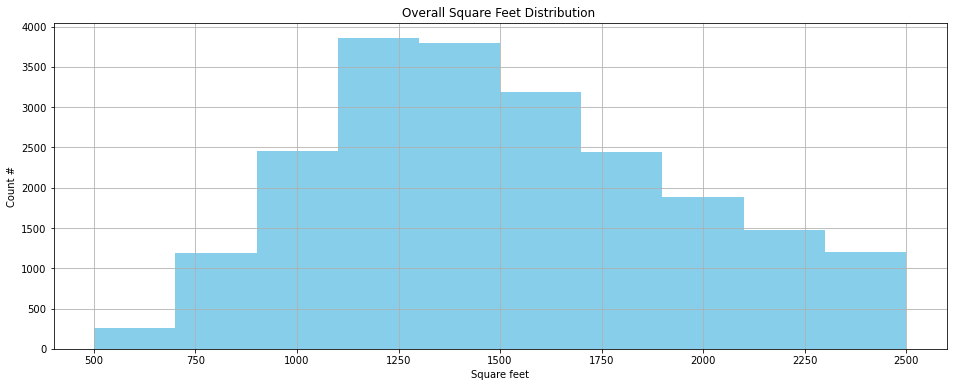

In [19]:
plt.figure(figsize = (16, 6))
plt.title('Overall Square Feet Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist(color = "skyblue", lw=0)
plt.show()

## (ii). Bedrooms & Bath Counts Distribution

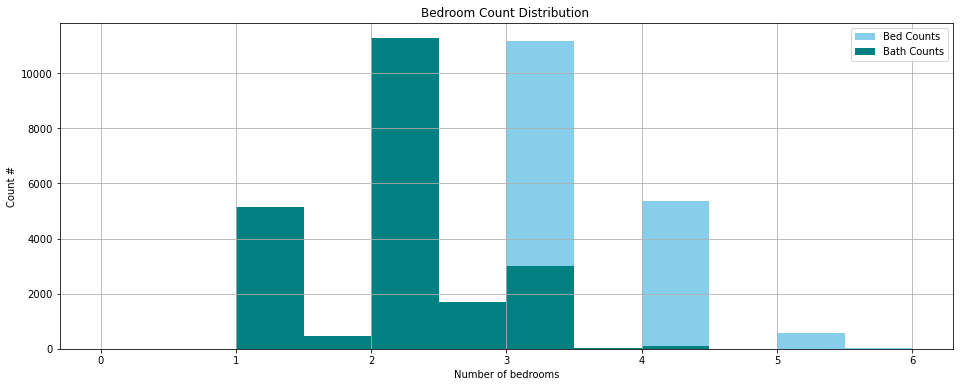

In [36]:
plt.figure(figsize = (16, 6))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist(color = "skyblue", lw=0, label = 'Bed Counts')
train.bath_count.hist(color = "teal", lw=0, label = 'Bath Counts')
plt.legend()
plt.show()

### (iii) Home Age/ Build year

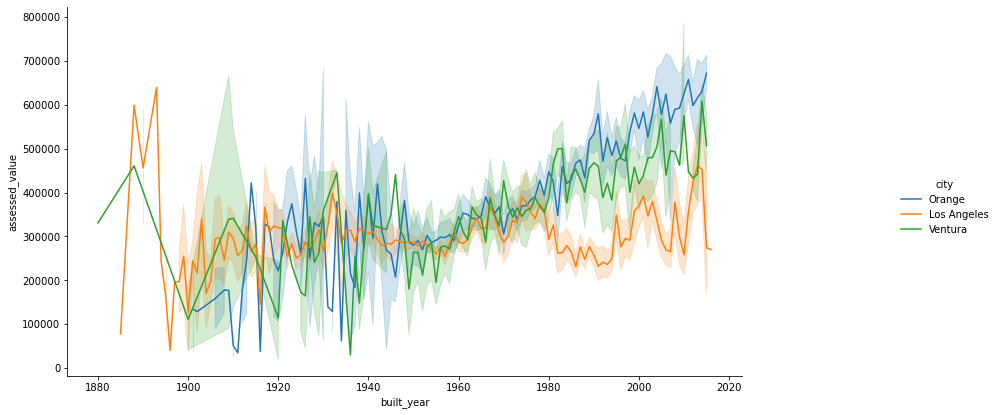

In [37]:

sns.relplot(data = train, x = 'built_year', y = 'assessed_value', hue = 'city', kind = 'line')
plt.gcf().set_size_inches(16, 6)


### (iv). Zip_code 

In [22]:
la_assessed_val_avg = train[train.city == 'Los Angeles'].assessed_value.mean()
ventura_assessed_val_avg = train[train.city == 'Ventura'].assessed_value.mean()
orange_assessed_val_avg = train[train.city == 'Orange'].assessed_value.mean()
print('\nMean average assessed tax values by counties\n')
print(f'\tL.A. County: --- {la_assessed_val_avg} \n\tVentura County: --- {ventura_assessed_val_avg}\n\tOrange County: --- {orange_assessed_val_avg}')


Mean average assessed tax values by counties

	L.A. County: --- 289952.93321460375 
	Ventura County: --- 360565.0263308529
	Orange County: --- 370287.64927857934


## Key Findings:
##### __NOTE:__ Some bed count and room counts were removed by the outlier functions as they were far and wide
- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s.
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s.
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Most transactions were average throughout the year but peaked towards the last few days of teh year.

## <u>Feature Engineering</u> 

##### What features are key predictors (correlates) with assessed value?

## Results
### (i). SelectKBest Test 

Index(['bed_count', 'bath_count', 'square_feet']

### (ii). Reccursive Feature Elimination

Index(['bed_count', 'bath_count', 'square_feet'],

### Feature Engineering Findings: 

>- __Bedroom count, Bathroom count & home square feet__ are KEY predictors of assessed value.


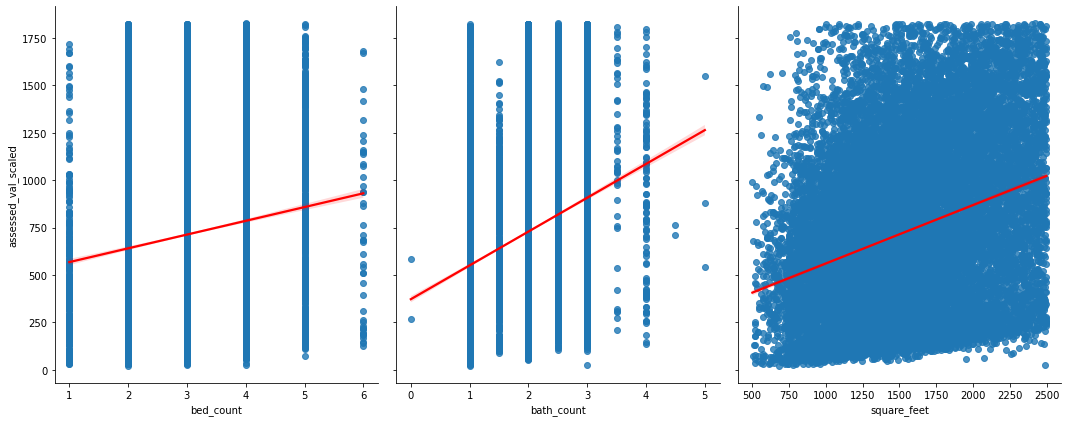

In [23]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['bed_count', 'bath_count', 'square_feet'], 
                 y_vars = ['assessed_val_scaled'])

g.fig.set_size_inches(16,7)

## Further Verification with SpearmanR Test

In [24]:
# Spearman (Normally distributed

zillow_spearman = train.drop(columns=['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled',
                                      'bath_scaled']).corr(method='spearman')
zillow_spearman


,bed_count,bath_count,square_feet,assessed_value
bed_count,1.000000,0.546268,0.590021,0.129102
bath_count,0.546268,1.000000,0.739430,0.274831
square_feet,0.590021,0.739430,1.000000,0.292677
assessed_value,0.129102,0.274831,0.292677,1.000000


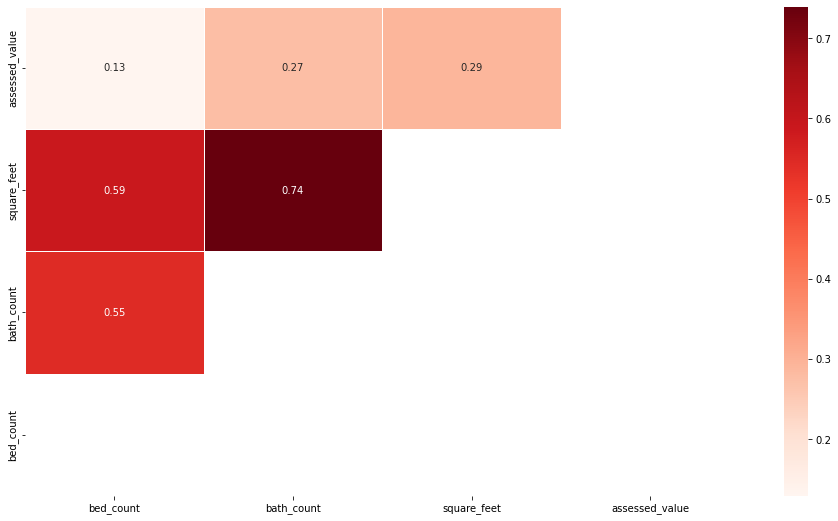

In [25]:
zillow_corr = train.drop(columns = ['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled','bath_scaled']).corr()

plt.figure(figsize=(16,9))

sns.heatmap(zillow_spearman, cmap='Reds', annot = True, linewidth=0.5, mask= np.triu(zillow_corr))

plt.ylim(0, 4)

plt.show()


# Exploration Phase Take Away: 

###    - Both SelectKBest & RFE conclude that the key features that correlates with assessed tax value are number of bathrooms, bedrooms & home\'s square feet.
####    - SpearmanR Assessed value correlation shows:
##        - 29% Square feet
##        - 27% Bathroom count
##        - 13% Bedroom count
    

# Phase V: 

>## <u>Modeling</u> 

## Models choosen: 

>- ### (a). Linear Regression
    
>- ### (b). Polynomial Regression
    
>- ### (c). Tweedie Regression (GLM)


### Set Driver Features of Interest

In [47]:
X_train = train[['bed_count', 'bath_count', 'square_feet']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet']]
y_test = test.assessed_value

### Create Baseline

In [63]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict asssessed_values_pred_mean
asssessed_value_pred_mean = y_train['assessed_value'].mean()
y_train['asssessed_value_pred_mean'] = asssessed_value_pred_mean
y_validate['asssessed_value_pred_mean'] = asssessed_value_pred_mean

# 2. compute asssessed_values_pred_median
asssessed_value_pred_median = y_train['assessed_value'].median()
y_train['asssessed_value_pred_median'] = asssessed_value_pred_median
y_validate['asssessed_value_pred_median'] = asssessed_value_pred_median

# 3. RMSE of asssessed_values_pred_mean
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_mean)**(1/2)

print("\nRMSE USING MEAN #1\n\tTrain/In-Sample:", round(rmse_train, 2),
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of asssessed_values_pred_median
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_median)**(1/2)

print("\n\nRMSE USING MEDIAN #1\n\tTrain/In-Sample: ", round(rmse_train, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))
print()


RMSE USING MEAN #1
	Train/In-Sample: 193231.11 
	Validate/Out-of-Sample:  193416.03


RMSE USING MEDIAN #1
	Train/In-Sample:  194294.19 
	Validate/Out-of-Sample:  194651.93



# Linear Regression (OLS) Model

In [64]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_val_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_val_pred_lm)**(1/2)

# predict validate
y_validate['assessed_val_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_val_pred_lm)**(1/2)
print()
print("RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:\n\n\tTraining/In-Sample: ", rmse_train, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate)
print()


RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:

	Training/In-Sample:  183077.00964762436 

	Validation/Out-of-Sample:  183293.08873430008



# ITERATION #1:  

>## Features of Interest:
>- ##### bed_count
>- ##### bath_count
>- ##### square_feet

<h1>SUMMARY 1</h1>

<h2>Features of interest: ('bed_count', 'bath_count', 'square_feet')</h2>


<hr>
<style>
td{
  font-size: 100px
}
</style>


<table style="width:100%, border: 1px solid green, border-collapse: collapse">
    
  <tr>
    <th>RMSE Mean Baseline </th>
    <th>RMSE Median Baseline</th>
    <th>RMSE Linear Regression Model</th>
    <th>RMSE Polynomial Regression Model</th>
    <th>RMSE TreedieRegression Model</th>

  </tr>

  <tr style="height:50px">
    <td>Train(in-sample): 193,231.11</td>
    <td>194,294.19</td>
    <td>183,077.01</td>
    <td>182,939.87</td>
    <td>193,231.11</td>

  </tr>

  <tr style="height:50px">
    <td>Validate(out-sample):  193,416.03</td>
    <td>194,651.93</td>
    <td>183,293.09</td>
    <td>183,306.67</td>
    <td>193,416.03</td>
  </tr>
   
</table>



### Linear Regression - Mean BaseLine
### Train Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,231.11) | -10,154.10 | -10,291.24 |  0.0  |


### Validate Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,416.03) | -10,122.94 | -10,109.36 |  0.0  |



# Evaluate Best Model (1st iteration):
- ##### The RMSE mean is lower than the Median Baseline, we will stick with the mean baseline
- ##### With train set, the Linear regression model performs overall best __-10,154.10__
- ##### With validate set, the Polynomial regression performs better than the other models __-10,109.36__


# Best Model (1st) == <u><b>Polynomial regression</b></u>

## Moving forward >>>> test adopted model on test set

In [65]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['assessed_val_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_value, y_test.assessed_val_pred_lm)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test)
print()


	RMSE for OLS Model using LinearRegression
	Out-of-Sample Performance:  183353.20727252585



>># Test data:

- ### 1st iteration polynomial Regression beats Baseline Tax Value of $193,231.11$ by predicting Tax value of $183,353.21$

<h1> ITERATION #2
    

>## Features of interest:
>- square_feet
>- built_year
>- zip_code 
>- bed_count
>- bath_count
>- square_feet
>- age_scaled
>- trans_month

<hr>

<style>
td {
  font-size: 50px
}
</style>
# SUMMARY


<table style="width:100%, border: 1px solid green, border-collapse: collapse">
    
  <tr style="height:50px">
    <th>RMSE Mean Baseline </th>
    <th>RMSE Median Baseline</th>
    <th>RMSE Linear Regression Model</th>
    <th>RMSE Polynomial Regression Model</th>
    <th>RMSE TreedieRegression Model</th>

  </tr>

  <tr style="height:50px">
    <td>Train(in-sample): 193,231.11</td>
    <td>194,294.19</td>
    <td>183,090.23</td>
    <td>180,645.72</td>
    <td>193,231.11 </td>

  </tr>

  <tr style="height:50px">
    <td>Validate(out-sample):  193,416.03</td>
    <td>194,651.93</td>
    <td>183,288.87</td>
    <td>180,576.66</td>
    <td>193,416.03</td>
  </tr>    
    
</table>

### Linear Regression - Mean BaseLine
### Train Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,231.11) | -10,140.88 | -12,585.39 |  0.0  |


### Validate Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,416.03) | -9,942.24| -12,654.45 |  0.0  |


## Evaluate Best Model:
- ##### The RMSE mean is lower than the Median Baseline, we will stick with the mean baseline
- ##### Both the train set & validation sets for Linear regression model performs overall best __-10,140.88 & -9,942.24__ respectively.

# Best model (2nd) == <u><b>Linear regression</b></u>

## Moving forward >>>> test adopted model on test set

In [85]:
y_test2 = pd.DataFrame(y_test2)

# predict on test
y_test2['assessed_val_pred_lm2_2'] = lm2_2.predict(X_test2)

# evaluate: rmse
rmse_test2 = mean_squared_error(y_test2.assessed_value, y_test2.assessed_val_pred_lm2_2)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test2)
print()

In [81]:
    RMSE for OLS Model using LinearRegression
    Out-of-Sample Performance:  186,430.67


>># Test data:

- ### 2nd iteration polynomial Regression beats Baseline Tax Value of $193,231.11$ by predicting Tax value of $186,353.21$

# Visualize Model Predictions

### Visualize Actual VS Predicted Assessed Value

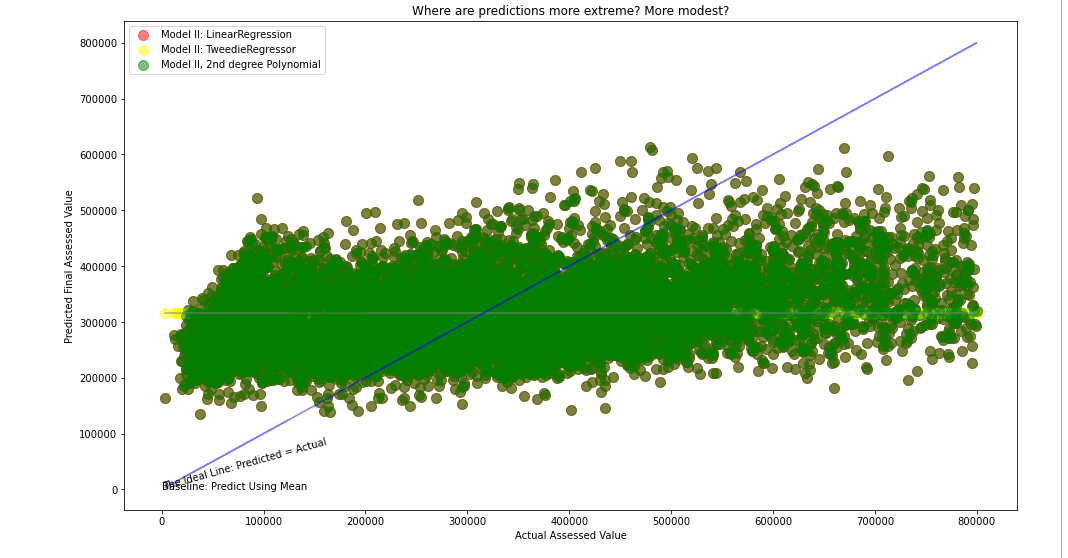

In [99]:
from IPython import display
display.Image("/Users/stephenkipkurui/Documents/codeup-data-science/regression-project/image2.png")

### Visualize Errors in prediction

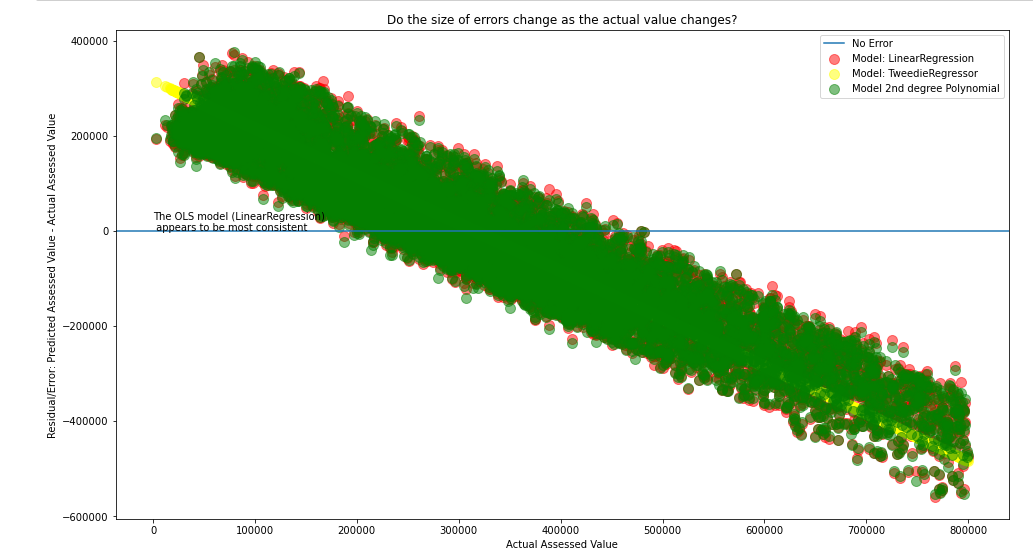

In [94]:
from IPython import display
display.Image("/Users/stephenkipkurui/Documents/codeup-data-science/regression-project/image1.png")

# Phase Vi
>## <u>Delivery & Presentation</u>

# Recommendations